In [38]:
def safe_log_transform(df, columns, skew_threshold=1.0):
    """
    For each metric (and its _DMC_10 counterpart), checks skewness and applies either:
    - log1p (if both are positive-only)
    - Yeo-Johnson (if either includes 0 or negative values)

    Only applies a transform if *either version* is skewed beyond threshold.

    Returns:
        transformed_df: df with added transformed columns
    """
    transformed_df = df.copy()
    checked = set()

    for col in columns:
        if col in checked:
            continue  # already processed as part of a pair

        dmc_col = col + '_DMC_10'
        pair = [col]
        if dmc_col in df.columns:
            pair.append(dmc_col)

        # Check skewness across the pair
        skews = {c: skew(df[c].dropna()) for c in pair}
        max_skew = max(abs(s) for s in skews.values())

        if max_skew <= skew_threshold:
            continue  # Skip transformation — not skewed enough

        # Determine appropriate transformation
        all_positive = all((df[c] > 0).all() for c in pair)
        if all_positive:
            for c in pair:
                transformed_df[c + '_log'] = np.log1p(df[c])
        else:
            transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            for c in pair:
                transformed_vals = transformer.fit_transform(df[c].values.reshape(-1, 1)).flatten()
                transformed_df[c + '_yj'] = transformed_vals
        checked.update(pair)

    return transformed_df


def plot_metric_histograms(df, columns=None, bins=30, skew_threshold=1.0):
    """
    Plots histograms for each metric column with skewness displayed.
    If no columns provided, uses all numeric columns.
    """
    if columns is None:
        columns = df.select_dtypes(include='number').columns

    n_cols = 3
    n_rows = int(np.ceil(len(columns) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        data = df[col].dropna()
        sk = skew(data)
        sns.histplot(data, bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(f"{col}\nSkewness: {sk:.2f}")
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_original_vs_transformed(df, original_columns):
    """
    Plots side-by-side histograms of original and transformed versions of each metric.
    Transformed versions are expected to be in columns named '<original>_log' or '<original>_yj'.
    """
    for col in original_columns:
        transformed_col = None
        if col + '_log' in df.columns:
            transformed_col = col + '_log'
        elif col + '_yj' in df.columns:
            transformed_col = col + '_yj'
        else:
            continue  # Skip if no transformed version exists

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Original
        sns.histplot(df[col].dropna(), bins=30, kde=True, ax=axes[0])
        orig_skew = skew(df[col].dropna())
        axes[0].set_title(f"Original: {col}\nSkewness: {orig_skew:.2f}")
        axes[0].set_ylabel("Frequency")

        # Transformed
        sns.histplot(df[transformed_col].dropna(), bins=30, kde=True, ax=axes[1])
        trans_skew = skew(df[transformed_col].dropna())
        axes[1].set_title(f"Transformed: {transformed_col}\nSkewness: {trans_skew:.2f}")
        axes[1].set_ylabel("Frequency")

        plt.tight_layout()
        plt.show()

def select_best_transformed_version(df):
    selected_cols = []

    # Get all base column names (before _log or _yj)
    base_cols = set(col.replace('_log', '').replace('_yj', '') for col in df.columns)

    for base in base_cols:
        log_col = base + '_log'
        yj_col = base + '_yj'

        if log_col in df.columns:
            selected_cols.append(log_col)
        elif yj_col in df.columns:
            selected_cols.append(yj_col)
        elif base in df.columns:
            selected_cols.append(base)
        # else: skip — no usable version of this metric

    return df[selected_cols].copy()


def safe_log_transform_old(df, columns, skew_threshold=1.0):
    """
    Applies log1p transformation to highly skewed, positive-only columns.
    For mixed or negative columns, applies Yeo-Johnson transformation instead.

    Returns a new DataFrame with log-transformed columns (originals unchanged).
    """
    from sklearn.preprocessing import PowerTransformer

    transformed_df = df.copy()
    skew_vals = df[columns].apply(skew)

    for col in skew_vals.index:
        if abs(skew_vals[col]) > skew_threshold:
            col_data = df[col]
            if (col_data <= 0).any():
                # Mixed or negative values: use Yeo-Johnson
                pt = PowerTransformer(method='yeo-johnson', standardize=False)
                transformed = pt.fit_transform(col_data.values.reshape(-1, 1)).flatten()
                transformed_df[col + '_yj'] = transformed
            else:
                # Positive-only: safe to use log1p
                transformed_df[col + '_log'] = np.log1p(col_data)
    
    return transformed_df

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
import seaborn as sns
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import MinMaxScaler, StandardScaler  
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from PlottingFunctions import *

## Read dataframe of results for all gauges

In [40]:
all_events =[]
for file in os.listdir("../DanishRainData_Outputs/5mins/"):
    df = pd.read_csv(f"../DanishRainData_Outputs/5mins/{file}")
    df['event_num']=range(0, len(df))
    all_events.append(df)
all_events_df = pd.concat(all_events)   

In [41]:
all_events_df.rename(columns={'4th_w_peak':"Huff quartile"}, inplace=True)
all_events_df.rename(columns={'4th_w_peak_DMC_10':"Huff quartile_DMC_10"}, inplace=True)
all_events_df.rename(columns={'3rd_w_peak':"Huff third"}, inplace=True)
all_events_df.rename(columns={'3rd_w_peak_DMC_10':"Huff third_DMC_10"}, inplace=True)
all_events_df.rename(columns={'5th_w_peak':"Huff quintile"}, inplace=True)
all_events_df.rename(columns={'5th_w_peak_DMC_10':"Huff quintile_DMC_10"}, inplace=True)
# all_events_df.rename(columns={'3rd_ARR':"3rd (w/ D50)"}, inplace=True)
# all_events_df.rename(columns={'3rd_ARR_DMC_10':"3rd (w/ D50)_DMC_10"}, inplace=True)

### remove events which are too small

In [42]:
print(len(all_events_df))
all_events_df = all_events_df[all_events_df['total_precip']>4].copy()
print(len(all_events_df))

539546
516453


### Remove normalisations we're not interested in (rn)

In [43]:
print(len(all_events_df.columns))
columns_to_drop = [col for col in all_events_df.columns if '_norm' in col or '_dblnorm' in col or 'DMC_100' in col]
all_events_df.drop(columns=columns_to_drop, inplace=True)
print(len(all_events_df.columns))
all_events_df.reset_index(inplace=True, drop=True)

132
132


### Remove columns we're not interested in (rn)

In [45]:
del all_events_df['BSC'], all_events_df['BSC_DMC_10']
del all_events_df['duration']
del all_events_df['total_precip']

### Delete problematic (np.nan) columns

In [46]:
cols_to_keep = all_events_df.columns
cols_to_del = ['min_intensity', 'min_intensity_DMC_10', 'frac_q1', 'frac_q2', 'frac_q3', 'frac_q4',
                   'frac_q1_DMC_10', 'frac_q2_DMC_10', 'frac_q3_DMC_10', 'frac_q4_DMC_10', 
              '% time HIZ', '% time HIZ_DMC_10','% time LIZ', '% rain HIZ', 'Mean Intensity HIZ',
              '% time LIZ_DMC_10', '% rain HIZ_DMC_10', 'Mean Intensity HIZ_DMC_10',
              'heaviest_half', 'heaviest_half_DMC_10',
              '3rd_com', 'event_loading_ghanghas_DMC_10', '3rd_com_DMC_10', 'Event Loading', '3rd_rcg','3rd_rcg_DMC_10', 
               'Event Loading_DMC_10', '3rd_rcg_DMC_10']

cols_to_keep = [x for x in cols_to_keep if x not in cols_to_del]  

all_events_df = all_events_df[cols_to_keep]

In [47]:
# Find columns with nan for 60 mins
columns_with_nan = all_events_df.columns[all_events_df.isnull().any()].tolist()
print("Columns with at least one NaN value:")
print(columns_with_nan)

Columns with at least one NaN value:
['asymm_d', 'lorentz_asymetry', 'lorentz_asymetry_DMC_10', 'event_loading_ghanghas']


In [48]:
# # Find indices of rows with any NaNs in the 60-minute data
bad_indices = all_events_df[all_events_df.isnull().any(axis=1)].index
len(bad_indices)
# Drop rows at these indices from all dataframes
all_events_df = all_events_df.drop(index=bad_indices)

del all_events_df['event_num']
all_events_df.reset_index(drop=True, inplace=True)

# Recheck for NANS
columns_with_nan = all_events_df.columns[all_events_df.isnull().any()].tolist()
print("Columns with at least one NaN value:")
print(columns_with_nan)

Columns with at least one NaN value:
[]


## Check skewness of variables

In [49]:
metric_columns = all_events_df.columns
metric_columns = metric_columns.drop(['gauge_num', "start_time", "end_time"])
all_events_df = all_events_df[metric_columns]

In [50]:
# plot_metric_histograms(all_events_df, columns=log_columns)

In [98]:
transformed_all_events_df = safe_log_transform(all_events_df, metric_columns)
transformed_all_events_df2 = select_best_transformed_version(transformed_all_events_df)
# transformed_all_events_df2 = all_events_df

In [15]:
# original_metric_columns = [col for col in all_events_df.columns 
#                            if not (col.endswith('_log') or col.endswith('_yj')) 
#                            and all_events_df[col].dtype.kind in 'fi']  # float/int only

# plot_original_vs_transformed(transformed_all_events_df, original_metric_columns)

## Standardise Data

In [118]:
metric_columns = transformed_all_events_df2.columns
standard_scaler = MinMaxScaler()
scaled_standard = standard_scaler.fit_transform(transformed_all_events_df2[metric_columns])

# Convert scaled values back to DataFrame and concatenate with original non-numeric columns
scaled_all_events_df = pd.DataFrame(scaled_standard, columns=metric_columns)
scaled_all_events_df = all_events_df
# scaled_all_events_df = pd.concat([cleaned_df[['gauge_num', "start_time", "end_time"]], scaled_all_events_df], axis=1)

In [119]:
metric_base_names = [col.replace(suffix, '') for col in all_events_df.columns  for suffix in ['_DMC_10']  if col.endswith(suffix)]

In [120]:
pearsonsr_ls = []
spearmansr_ls = []
metric_names = []
suffixes = ['', '_log', '_yj']

for i, base_name in enumerate(metric_base_names):
    found_pair = False
    for suffix in suffixes:
        col1 = base_name + suffix
        col2 = base_name + '_DMC_10' + suffix

        if col1 in scaled_all_events_df.columns and col2 in scaled_all_events_df.columns:
            x = scaled_all_events_df[col1]
            y = scaled_all_events_df[col2]
            
            pearsonsr_ls.append(pearsonr(x, y)[0])
            spearmansr_ls.append(spearmanr(x, y)[0])
            metric_names.append(base_name + suffix)
            found_pair = True
            break  # stop after finding first matching suffix pair
            
    if not found_pair:
        print(f"No matching pair found for metric '{base_name}' with any suffix")

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/scipy/stats/stats.py:3875: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [121]:
metric_scores = pd.DataFrame({'Metric':metric_names,
                             "pearsonsr_logtransform": pearsonsr_ls, "spearmansr_logtransform": spearmansr_ls})
# metric_scores.sort_values(by="pearsonsr", ascending=False, inplace=True)
# sorted_metrics = metric_scores.sort_values(by="pearsonsr", ascending=False)['Metric'].values
# cleaned_sorted_metrics = [m.replace('_log', '').replace('_yj', '') for m in sorted_metrics]

In [122]:
def remove_transform_suffix(metric_name):
    if metric_name.endswith('_log'):
        return metric_name[:-4]
    elif metric_name.endswith('_yj'):
        return metric_name[:-3]
    else:
        return metric_name

# Create base metric columns in both DataFrames
metric_scores_notransformations['Metric_base'] = metric_scores_notransformations['Metric'].apply(remove_transform_suffix)
metric_scores['Metric_base'] = metric_scores['Metric'].apply(remove_transform_suffix)

# Now merge on 'Metric_base'
merged_df = metric_scores_notransformations.merge(
    metric_scores,
    on='Metric_base',
    how='left',  # or 'inner' if you want only matched metrics
    suffixes=('_noTrans', '_logTrans')
)

# If you want, you can drop duplicate columns or reorder after merging
del merged_df['Metric_noTrans']
del merged_df['Metric_logTrans']
cols = list(merged_df)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Metric_base')))
# use ix to reorder
merged_df = merged_df.loc[:, cols]
merged_df['pearsonsr_diff'] = merged_df['pearsonsr'] -  merged_df['pearsonsr_logtransform']
merged_df['spearmans_diff'] = merged_df['spearmansr'] -  merged_df['spearmansr_logtransform']
merged_df

,Metric_base,pearsonsr,spearmansr,pearsonsr_logtransform,spearmansr_logtransform,pearsonsr_diff,spearmans_diff
0,m3_wi,1.000000,0.999973,1.000000,0.999973,0.000000e+00,0.000000e+00
1,centre_gravity_interpolated,0.994972,0.994677,0.994972,0.994677,1.110223e-16,2.227557e-10
2,time_skewness,0.994405,0.995015,0.994405,0.995015,3.330669e-16,4.291402e-08
3,D50,0.992530,0.992786,0.992530,0.992785,0.000000e+00,4.240600e-07
4,T50,0.992530,0.992786,0.992530,0.992785,0.000000e+00,4.240600e-07
5,T75,0.991941,0.988326,0.991941,0.988326,0.000000e+00,-1.095976e-08
6,T25,0.990677,0.971285,0.990677,0.971284,2.220446e-16,1.067486e-07
7,m4_wi,0.988449,0.987990,0.988449,0.987990,1.110223e-16,0.000000e+00
8,m5_wi,0.986682,0.986262,0.986682,0.986262,1.110223e-16,0.000000e+00
9,time_kurtosis,0.981313,0.994509,0.981313,0.994509,0.000000e+00,-2.791970e-10


In [97]:
# metric_scores_notransformations = metric_scores.copy()

## Create correlation matrix

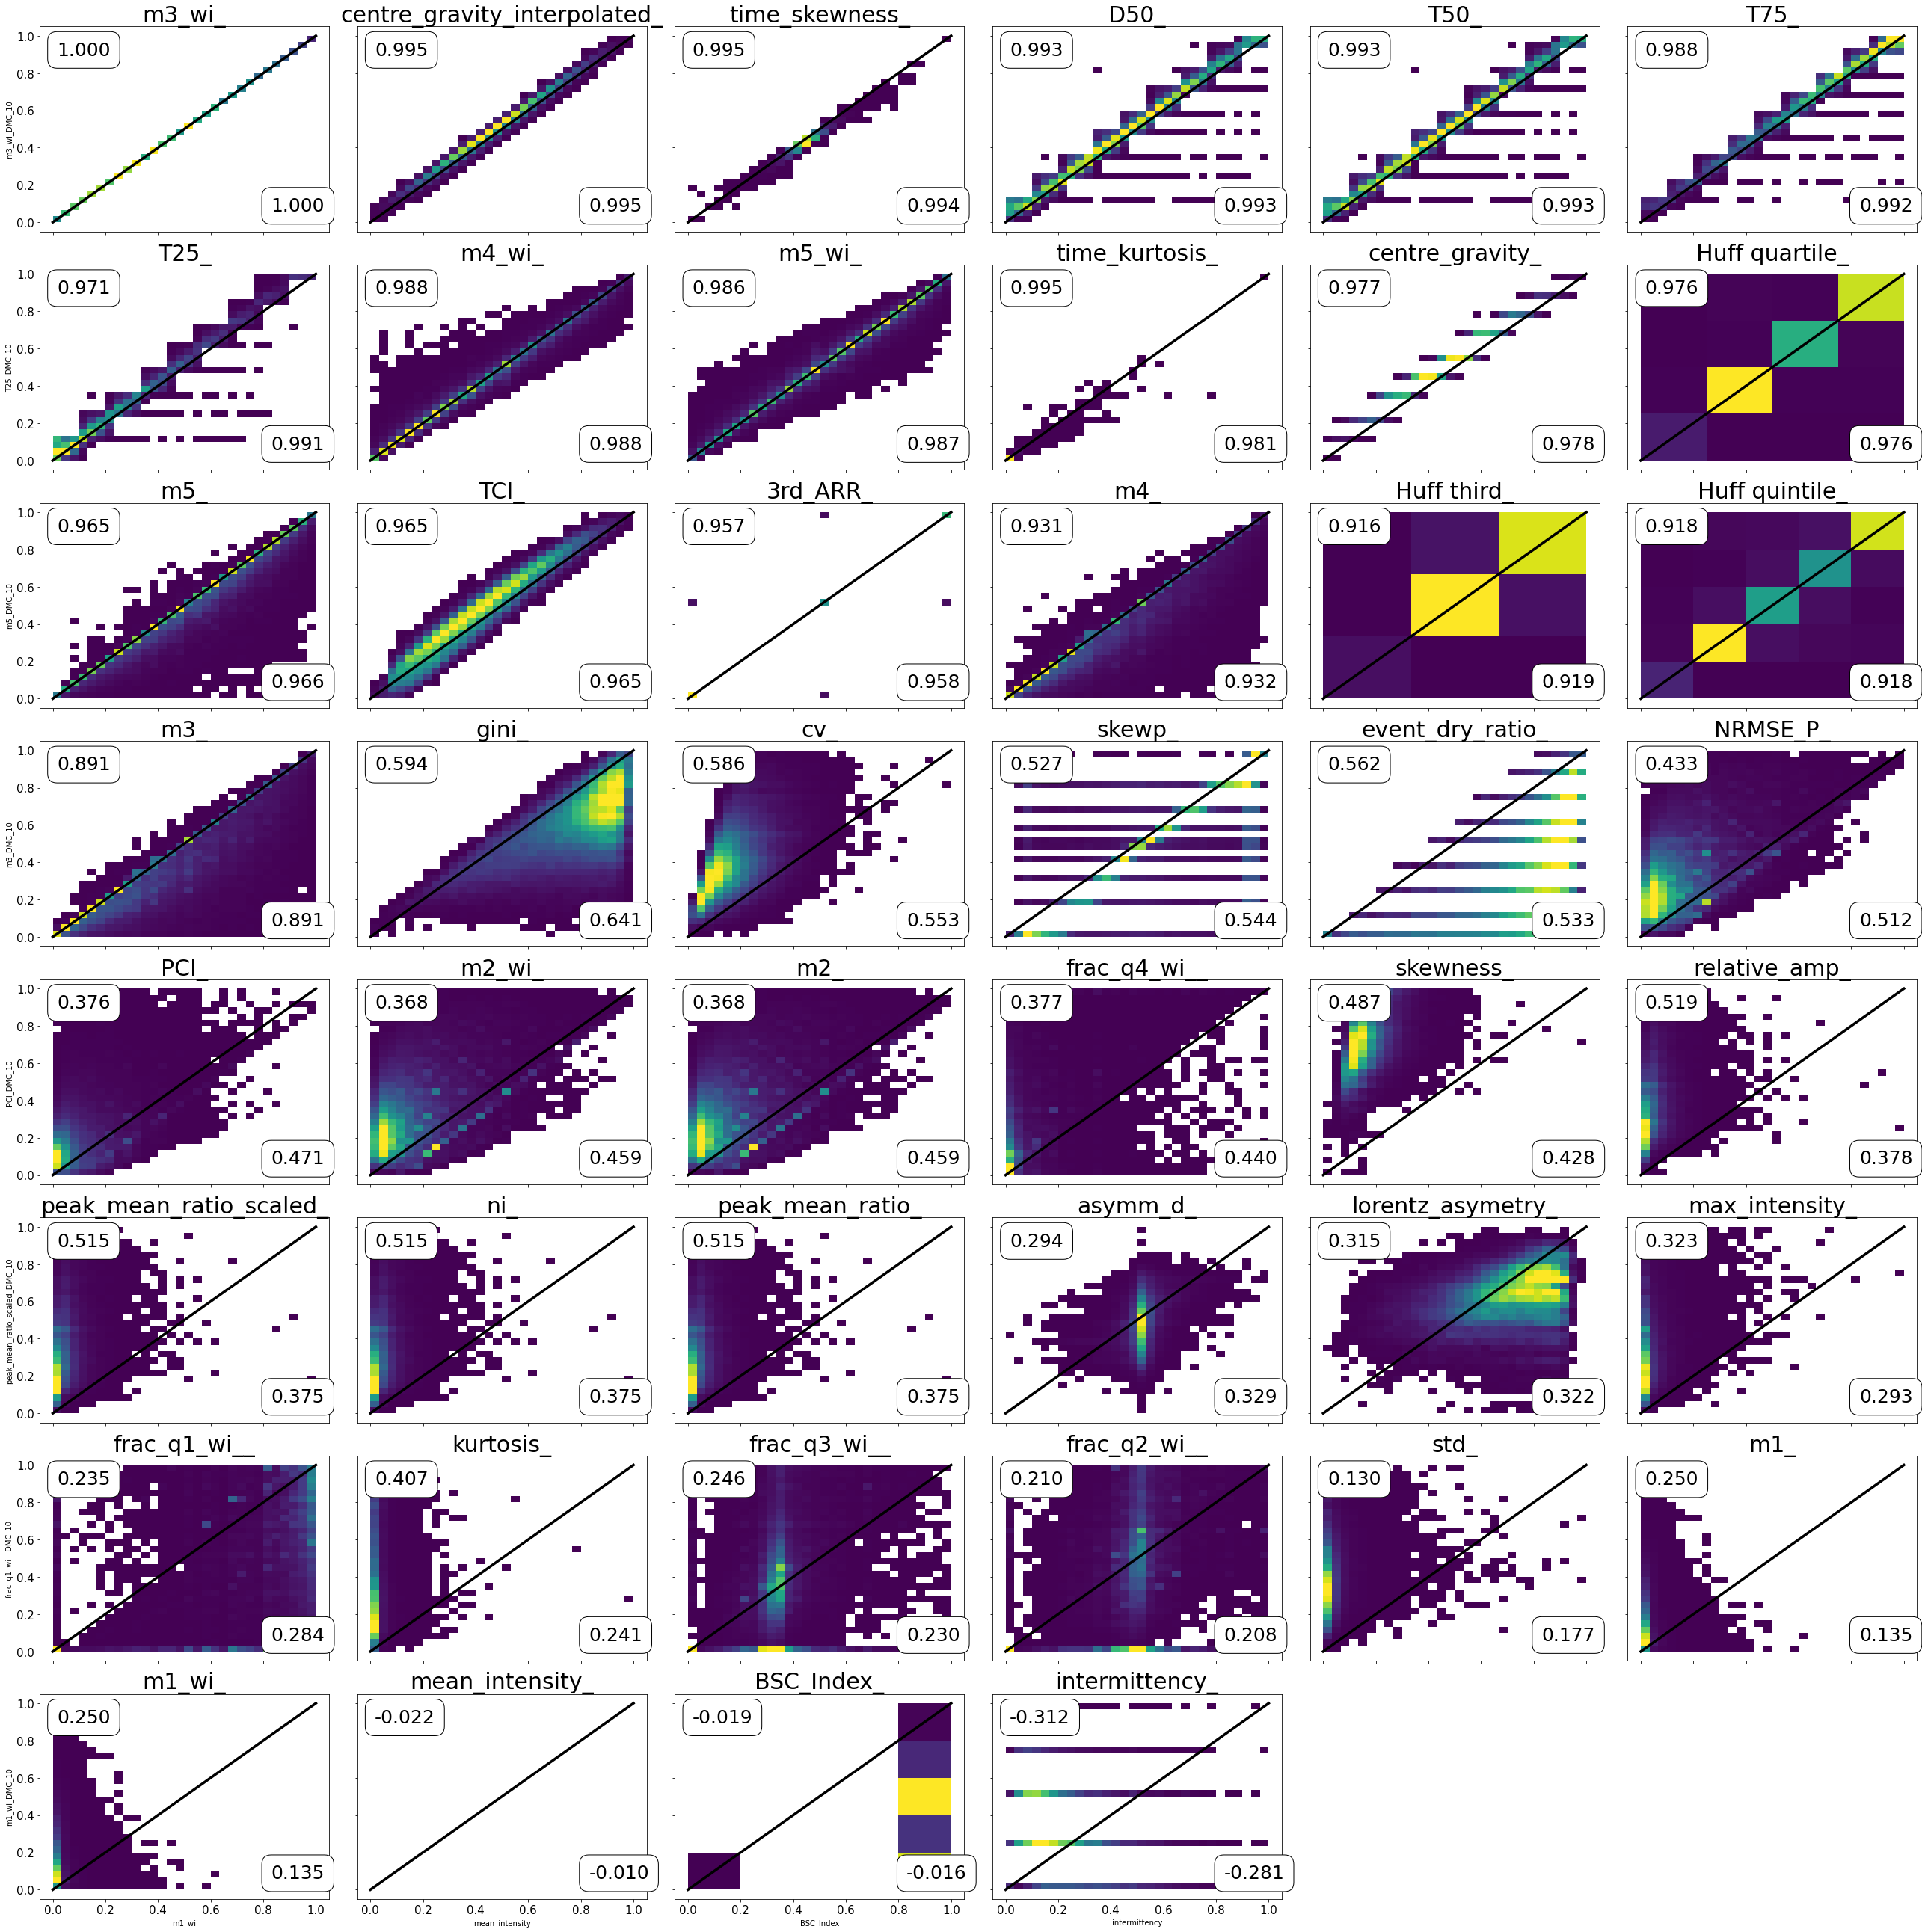

In [93]:
# Define suffixes to consider, ordered by preference
suffixes = ['', '_log', '_yj']

n_metrics = len(metric_base_names)
n_cols = 6
n_rows = int(np.ceil(n_metrics / n_cols))

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4.5 * n_rows), sharex=True, sharey=True)
axs = axs.flatten()

for i, base_name in enumerate(cleaned_sorted_metrics):
    
    if base_name == 'Huff quartile':
        bins=4
    elif base_name == 'Huff quintile':
        bins=5   
    elif base_name == 'Huff third' or base_name =='3rd (w/ D50)' or base_name == '3rd_com':
        bins=3
    elif base_name == 'BSC_Index':
        bins=5
    else:
        bins=30
    
    found_pair = False
    for suffix in suffixes:
        col1 = base_name + suffix
        col2 = base_name + '_DMC_10' + suffix

        if col1 in scaled_all_events_df.columns and col2 in scaled_all_events_df.columns:
            ax = axs[i]
            x = scaled_all_events_df[col1]
            y = scaled_all_events_df[col2]

            sns.histplot(x=x, y=y, bins=bins, pmax=0.9, ax=ax, cmap="viridis", cbar=False)
            ax.set_title(f"{base_name} {suffix if suffix else '(raw)'}", fontsize=30)
            ax.set_title(f"{base_name}_{suffix}", fontsize=30)
            found_pair = True
            
            min_val = min(np.min(x), np.min(y))
            max_val = max(np.max(x), np.max(y))
            ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='solid', linewidth=3.5, label='1:1 Line')
            
            pearsons_r = pearsonr(x, y)[0]
            spearmans_r = spearmanr(x, y)[0]
            
            ax.annotate(f"{pearsons_r:.3f}", 
                    xy=(0.80, 0.1), xycoords='axes fraction',
                    fontsize=25, color='black', 
                    # ha='right', va='bottom',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
            ax.annotate(f"{spearmans_r:.3f}", 
                    xy=(0.06, 0.86), xycoords='axes fraction',
                    fontsize=25, color='black', 
                    # ha='right', va='bottom',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))    
            
            ax.tick_params(axis='both', which='major', labelsize=15)
            
            break  # stop after finding first matching suffix pair
            
    if not found_pair:
        print(f"No matching pair found for metric '{base_name}' with any suffix")

# Remove unused axes if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Plot correlation matrix

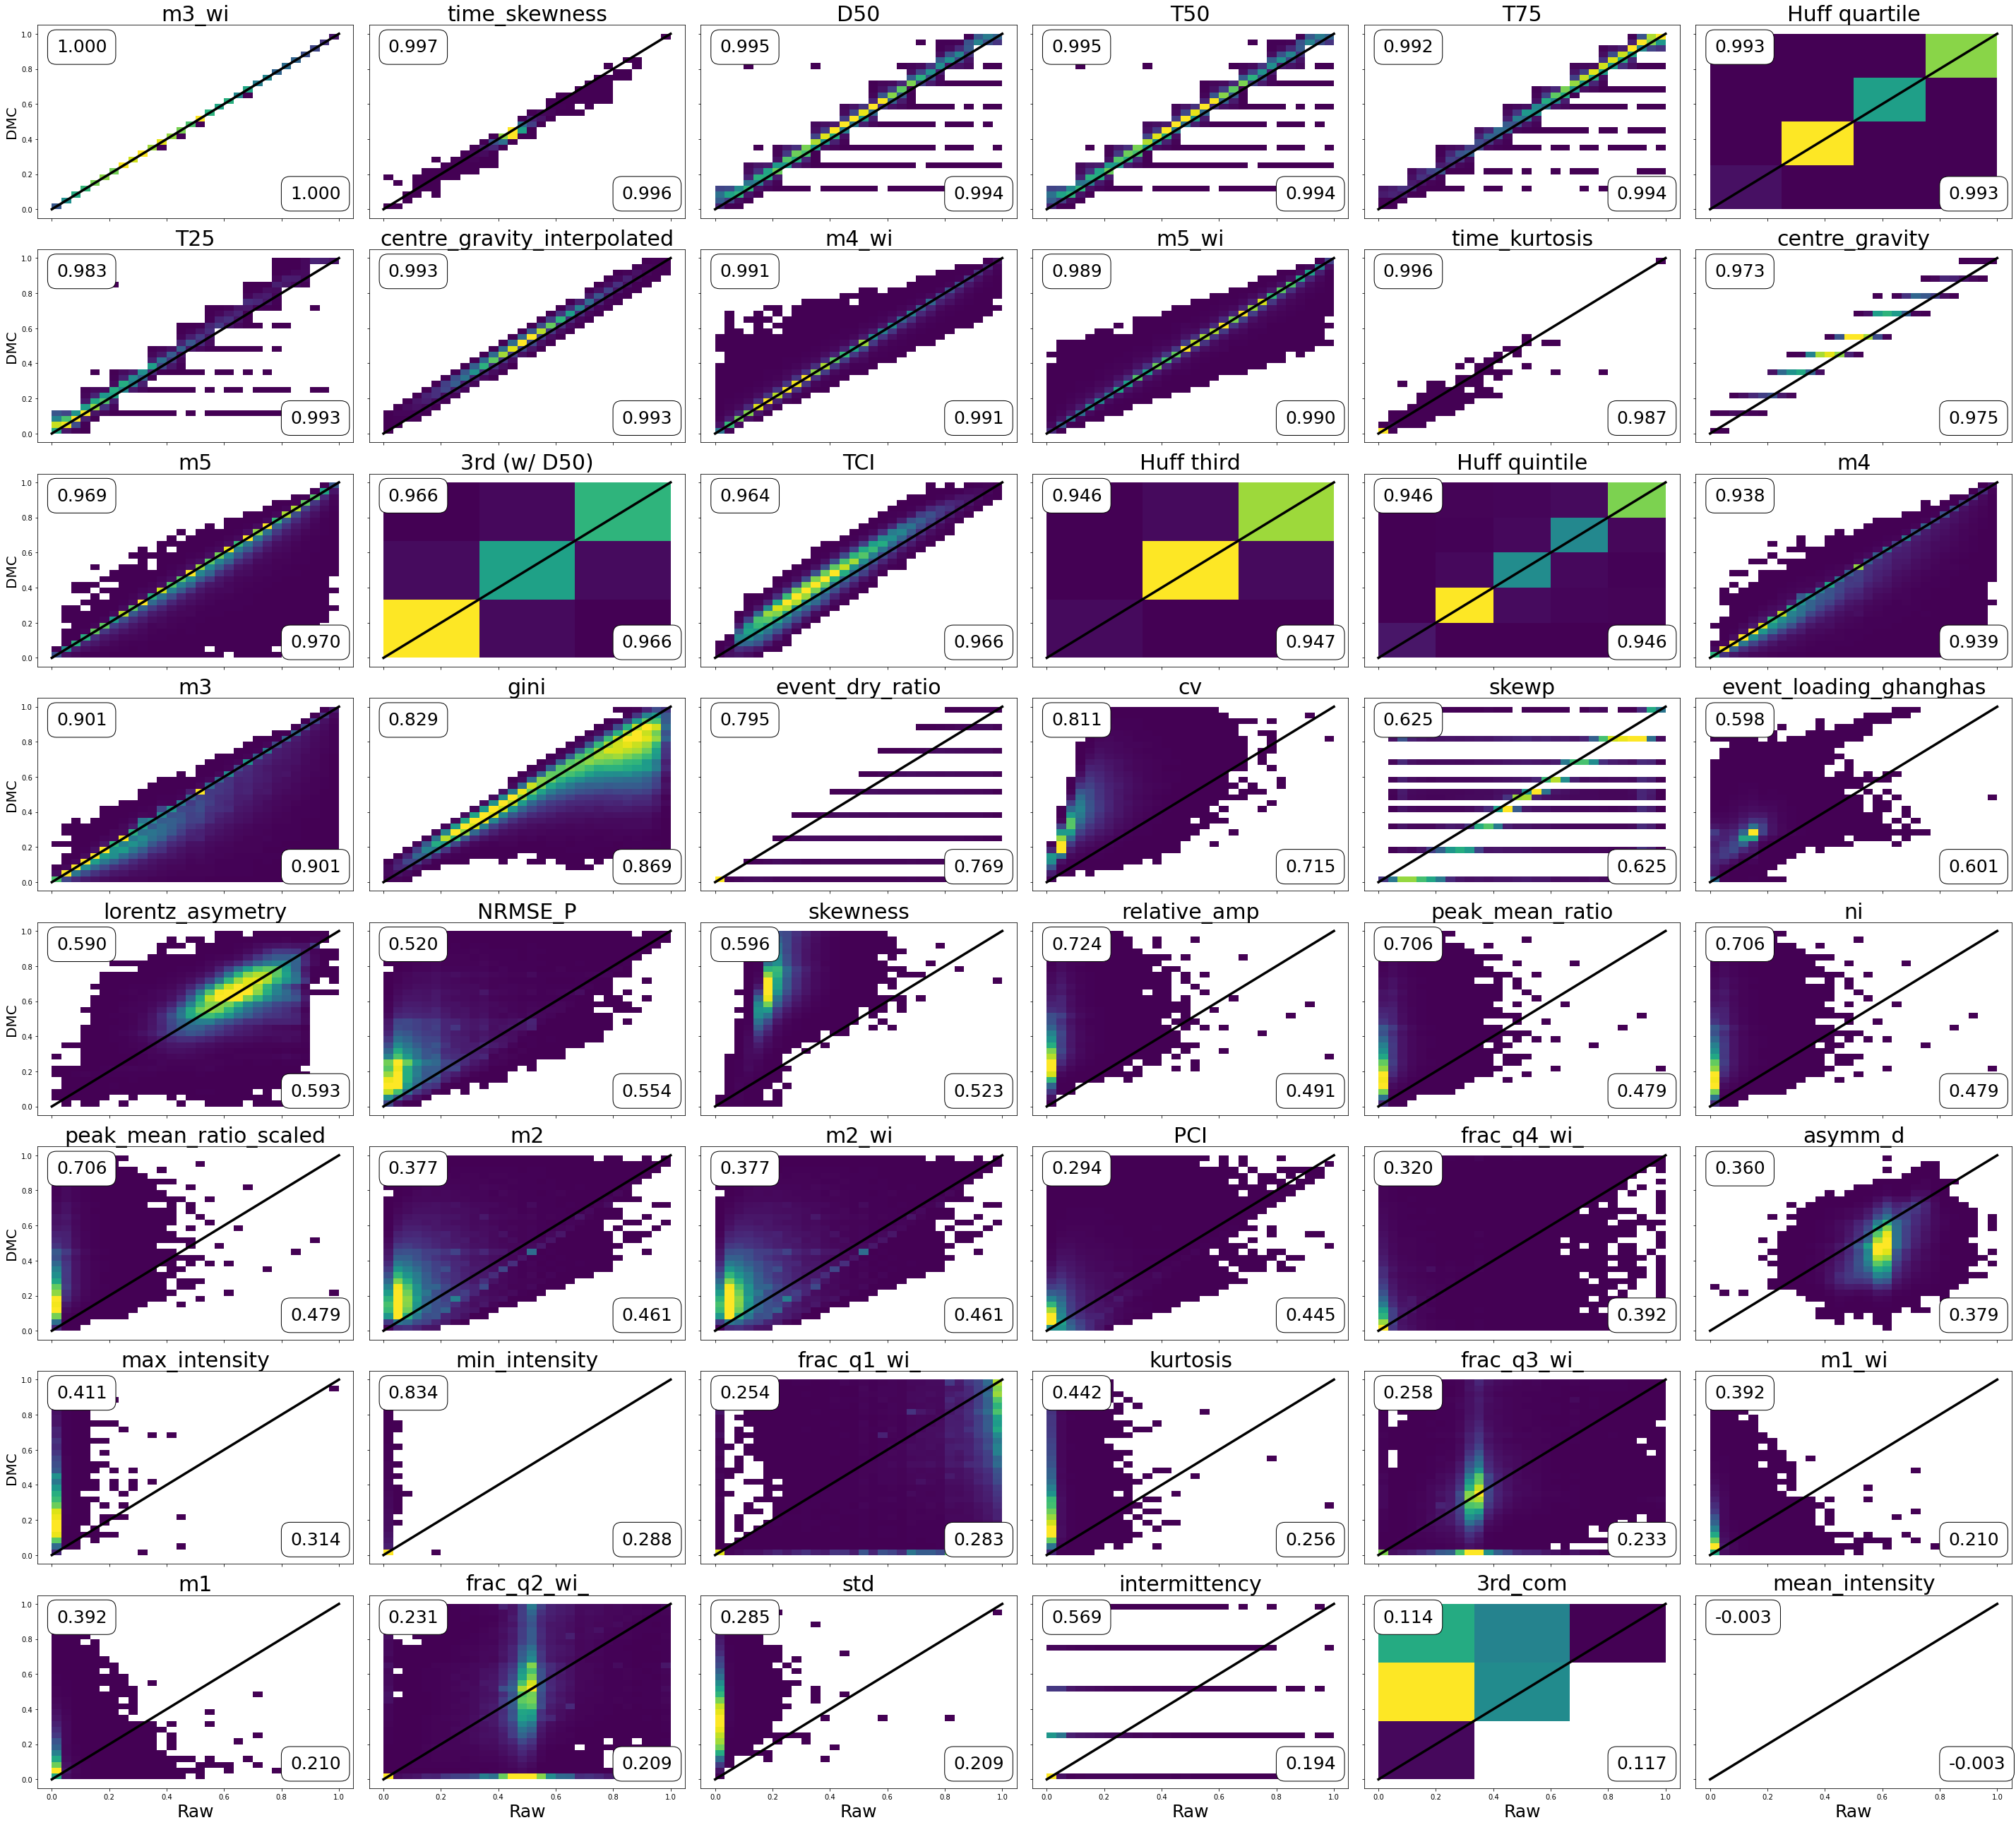

In [99]:
fig, axs = plt.subplots(nrows=8, ncols=6, figsize=(40, 36), sharex=True, sharey=True)

for ax_num, ax in enumerate(axs.flatten()):
    if ax_num < len(comparison_df['metric']):
        metric = comparison_df['metric'][ax_num]
        x = all_events_df[f'{metric}']
        y = all_events_df[f'{metric}_DMC_10']
        
        # Remove NaNs
        mask = ~x.isna() & ~y.isna()
        x = x[mask]
        y = y[mask]
        
        scaler = MinMaxScaler()
        x_scaled = scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten()  # Reshape for scaler and flatten back
        y_scaled = scaler.fit_transform(np.array(y).reshape(-1, 1)).flatten()
        
        if metric == 'Huff quartile':
            bins=4
        elif metric == 'Huff quintile':
            bins=5   
        elif metric == 'Huff third' or metric =='3rd (w/ D50)' or metric == '3rd_com':
            bins=3
        elif metric == 'BSC_Index':
            bins=5
        else:
            bins=30
        
        # Density plot
        sns.histplot(x=x_scaled, y=y_scaled, bins=bins, pmax=0.9, ax=ax, cmap="viridis", cbar=False)
        # ax.set_title(f"{metric}\n Pearson's R: {comparison_df.iloc[ax_num]['pearson_r']:.3f}", fontsize=20)
        ax.set_title(metric, fontsize=30)
        if ax_num >30:
            ax.set_xlabel('Raw', fontsize=25)
        if ax_num in [0, 6, 12, 18, 24, 30, 36]:            
            ax.set_ylabel('DMC', fontsize=20)
        ax.annotate(f"{comparison_df.iloc[ax_num]['pearson_r']:.3f}", 
                    xy=(0.80, 0.1), xycoords='axes fraction',
                    fontsize=25, color='black', 
                    # ha='right', va='bottom',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        ax.annotate(f"{comparison_df.iloc[ax_num]['spearman_rho']:.3f}", 
                    xy=(0.06, 0.86), xycoords='axes fraction',
                    fontsize=25, color='black', 
                    # ha='right', va='bottom',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))        
        
        min_val = min(np.min(x_scaled), np.min(y_scaled))
        max_val = max(np.max(x_scaled), np.max(y_scaled))
        ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='solid', linewidth=3.5, label='1:1 Line')

    else:
        ax.set_axis_off()

plt.tight_layout()
fig.savefig("Figures/DMC_Raw_Comparison.png", facecolor='white', edgecolor='white', dpi=50)

### Plot Bland Altman Plot

In [94]:
# plot_bland_altman_grid(bland_altman_data, plots_per_row=6)